# Read the files

In [160]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")
library("parallelMap")
library("ggthemr")

ggthemr("fresh")

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

In [161]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [162]:
cols_with_low_iv_values %>% cat(sep = " \n ")

nbrhud_comm_180d_violation_cnt 
 zone_type 
 mos_species 
 ses_lt_hs_pct_tract2017 
 loc_lat_lng_src 
 nbrhud_blk_grp_180d_violation_cnt 
 nbrhud_zipcode_180d_violation_cnt 
 t_day_of_yr 
 trap_trap_type 
 mos_salinarius_num_mosquitos 
 mos_unspecified_num_mosquitos 
 mos_erraticus_num_mosquitos 
 mos_tarsalis_num_mosquitos 
 trap_satellite_ind 
 t_day 
 mos_territans_num_mosquitos 
 nbrhud_comm_180d_vacancies_cnt 
 wea_ohare_tavg2_ma7 
 nbrhud_blk_grp_180d_vacancies_cnt 
 nbrhud_zipcode_180d_vacancies_cnt 
 wea_ohare_prcp 
 googtrend_deadbirds 
 wea_ohare_prcp_sum7 
 mos_restuans_num_mosquitos 
 wea_ohare_tavg2_ma60_lag21 
 wea_ohare_tmax 
 wea_ohare_prcp_sum60_lag7


# Little cleanup

In [163]:
# Remove cols_with_low_iv_values to make life a bit simplier

#df_train = df_train %>% select(-cols_with_low_iv_values)
#df_val = df_val %>% select(-cols_with_low_iv_values)

In [164]:
df_train = df_train %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)
df_val = df_val %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)

In [165]:
stopifnot(df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x))) == 
              df_val %>% select_if(is.factor) %>% map_int(~length(levels(.x))))

## Remove NA rows from val set

In [166]:
df_val = df_val[complete.cases(df_val),]

## Make y the 1st col

In [167]:
make_resp_first_var = function(df){
    pred_cols = names(df %>% select(-y))
    df %>% select(y, pred_cols)
}

In [168]:
df_train = df_train %>% make_resp_first_var
df_val   = df_val   %>% make_resp_first_var

In [169]:
dim(df_train)

[1] 15257    64

In [170]:
dim(df_val)

[1] 5903   64

In [171]:
predictors = df_train %>% select(-y) %>% names

Number of levels of all factor vars:

In [172]:
df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x)))

y             t_mo            t_qtr t_day_of_wk_name 
               2                6                3                5 
 loc_lat_lng_src      loc_zipcode       zone_class        zone_type 
               2               47               38                7 
  trap_trap_type      mos_species 
               4                8

## Putting train & val data together

Since `mlr` can handle these data together (much easier) using either holdout, or 5-fold CV, I'm putting these two sets together again.

In [173]:
df_model = df_train %>% bind_rows(df_val)

In [174]:
dim(df_model)

[1] 21160    64

In [175]:
cat("Holdout % : ", round(nrow(df_train)/nrow(df_model),3))

Holdout % :  0.721

# Model Setup

## Preprocess Data

wnv = createDummyFeatures(df_model,target = "y")
wnv = removeConstantFeatures(wnv)

dim(wnv)

glimpse(wnv)

Creating data with **NO** mosquito variables - like mos species count, or mos species information 

df_model_no_mos = df_model %>% select(-starts_with("mos"),-woe_mos_species) %>% distinct()
wnv_no_mos = createDummyFeatures(df_model_no_mos,target = "y")
wnv_no_mos = removeConstantFeatures(wnv_no_mos)

dim(wnv_no_mos)

Creating data with **NO** species variables but including the mos species count

In [176]:
df_model_no_mos = df_model %>% select(-starts_with("mos"),-woe_mos_species) %>% 
    bind_cols(df_model["mos_tot_num_mosquitos"]) %>% distinct()
wnv_mos_count = createDummyFeatures(df_model_no_mos,target = "y")
wnv_mos_count = removeConstantFeatures(wnv_mos_count)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


In [177]:
dim(wnv_mos_count)

[1] 11591   156

In [178]:
glimpse(wnv_mos_count)

Observations: 11,591
Variables: 156
$ y                                 <fct> Clean, Clean, Clean, Clean, Clean...
$ t_day                             <int> 29, 29, 29, 29, 29, 29, 29, 29, 2...
$ t_wk                              <int> 22, 22, 22, 22, 22, 22, 22, 22, 2...
$ t_day_of_yr                       <int> 149, 149, 149, 149, 149, 149, 149...
$ t_day_of_wk                       <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
$ t_eval_day                        <int> 514, 514, 514, 514, 514, 514, 514...
$ t_eval_wk                         <int> 74, 74, 74, 74, 74, 74, 74, 74, 7...
$ loc_lat                           <dbl> 41.95630, 41.99549, 41.97418, 41....
$ loc_lng                           <dbl> -87.79752, -87.76961, -87.82524, ...
$ trap_satellite_ind                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ ses_lt_hs_pct_blk_grp2017         <dbl> 17.4209547, 4.8346056, 3.5010941,...
$ ses_median_hh_inc_blk_grp2017     <int> 39643, 84073, 101101, 91094, 3823...
$ ses_lt_pov_pct

## Create Classification Task & Split

tsk = makeClassifTask(data = wnv, target = "y", positive = "Infected")
tsk

tsk_no_mos = makeClassifTask(data = wnv_no_mos, target = "y", positive = "Infected")
tsk_no_mos

In [179]:
tsk_mos_count = makeClassifTask(data = wnv_mos_count, target = "y", positive = "Infected")
tsk_mos_count

Supervised task: wnv_mos_count
Type: classif
Target: y
Observations: 11591
Features:
   numerics     factors     ordered functionals 
        155           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   10291     1300 
Positive class: Infected

# Feature Importance

fv = generateFilterValuesData(tsk, method = "anova.test")
fv

options(repr.plot.width=7, repr.plot.height=3.5)
plotFilterValues(fv) + 
    labs(title="Anova Test Result for WNV Training Data", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

fv = generateFilterValuesData(tsk, method = c("randomForest.importance"))
fv

plotFilterValues(fv,facet.wrap.nrow = 2) + 
    labs(title="Random Forest Importance Plot", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

## Build the model

In [180]:
### rdesc = makeResampleDesc("Holdout", stratify = FALSE, split = 0.721)
rdesc = makeResampleDesc("CV", stratify = TRUE, iters = 3)

lrns = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob"),
            makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
            makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
            makeLearner(id = "adaboost", cl = "classif.adaboostm1", predict.type = "prob"),
            makeLearner(id = "cforest", cl = "classif.cforest", predict.type = "prob"),
            makeLearner(id = "C50", cl = "classif.C50", predict.type = "prob"),
            makeLearner(id = "gbm", cl = "classif.gbm", predict.type = "prob"),
            makeLearner(id = "dbnDNN", cl = "classif.dbnDNN", predict.type = "prob"),
            makeLearner(id = "svm", cl = "classif.svm", predict.type = "prob"),
            makeLearner(id = "svm_radial", cl = "classif.svm", predict.type = "prob", kernel = "radial"),
            makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

#makePreprocWrapperCaret(makeLearner(id = "eTrees_norm","classif.evtree",predict.type = "prob"), ppc.center = TRUE, ppc.scale = TRUE)

In [181]:
costs = matrix(c(0, 1, 4, 0), 2)
colnames(costs) = rownames(costs) = c("Infected","Clean")
costs

,Infected,Clean
Infected,0,4
Clean,1,0


In [182]:
th = costs[2,1]/(costs[2,1] + costs[1,2])
th

[1] 0.2

In [183]:
wnv.costs = makeCostMeasure(id = "wnv.costs", name = "WNV costs", costs = costs, best = 0, worst = 5)
wnv.costs

Name: WNV costs
Performance measure: wnv.costs
Properties: classif,classif.multi,req.pred,req.truth,predtype.response,predtype.prob
Minimize: TRUE
Best: 0; Worst: 5
Aggregated by: test.mean
Arguments: costs=<matrix>, combine=<function>
Note: 

In [184]:
meas = list(auc, mmce, f1, tpr, fpr, fnr, ppv, wnv.costs)
meas

[[1]]
Name: Area under the curve
Performance measure: auc
Properties: classif,req.pred,req.truth,req.prob
Minimize: FALSE
Best: 1; Worst: 0
Aggregated by: test.mean
Arguments: 
Note: Integral over the graph that results from computing fpr and tpr for many different thresholds.

[[2]]
Name: Mean misclassification error
Performance measure: mmce
Properties: classif,classif.multi,req.pred,req.truth
Minimize: TRUE
Best: 0; Worst: 1
Aggregated by: test.mean
Arguments: 
Note: Defined as: mean(response != truth)

[[3]]
Name: F1 measure
Performance measure: f1
Properties: classif,req.pred,req.truth
Minimize: FALSE
Best: 1; Worst: 0
Aggregated by: test.mean
Arguments: 
Note: Defined as: 2 * tp/ (sum(truth == positive) + sum(response == positive))

[[4]]
Name: True positive rate
Performance measure: tpr
Properties: classif,req.pred,req.truth
Minimize: FALSE
Best: 1; Worst: 0
Aggregated by: test.mean
Arguments: 
Note: Percentage of correctly classified observations in the positive class. Also cal

bmr = readRDS('large_cache/bmr_001.RData')
#parallelStartSocket(cpus = 39)
#bmr = benchmark(learners = lrns, tasks = tsk, resamplings = rdesc, measures = meas, show.info = TRUE)
#parallelStop()

In [185]:
lrn_list = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=35, predict.threshold = th),
                makeLearner(id = "c50", cl = "classif.C50", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "glmnet", cl = "classif.cvglmnet", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "lasso", cl = "classif.LiblineaRL1LogReg", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 35, predict.threshold = th))

In [186]:
task_list = list(tsk_mos_count)

In [187]:
parallelStartSocket(cpus = 39)
bmr = benchmark(learners = lrn_list, tasks = task_list, resamplings = rdesc, measures = meas, show.info = TRUE)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 7.
Stopped parallelization. All cleaned up.


In [188]:
bmr

        task.id learner.id auc.test.mean mmce.test.mean f1.test.mean
1 wnv_mos_count      rpart     0.7523191      0.1131055    0.5123676
2 wnv_mos_count         rf     0.8892537      0.1426107    0.5293650
3 wnv_mos_count        xgb     0.8794672      0.8878440    0.2016911
4 wnv_mos_count        c50     0.8061552      0.1411437    0.5148764
5 wnv_mos_count     glmnet     0.8715046      0.1301019    0.5209115
6 wnv_mos_count      lasso     0.8604766      0.1524472    0.4832118
7 wnv_mos_count extraTrees     0.8659880      0.1540847    0.4946283
  tpr.test.mean fpr.test.mean fnr.test.mean ppv.test.mean wnv.costs.test.mean
1     0.5292586    0.06792247     0.4707414     0.5000027           0.2715040
2     0.7153908    0.12467246     0.2846092     0.4202466           0.2383738
3     1.0000000    1.00000000     0.0000000     0.1121560           0.8878440
4     0.6622411    0.11631868     0.3377589     0.4275571           0.2547674
5     0.6299795    0.09979657     0.3700205     0.4441914 

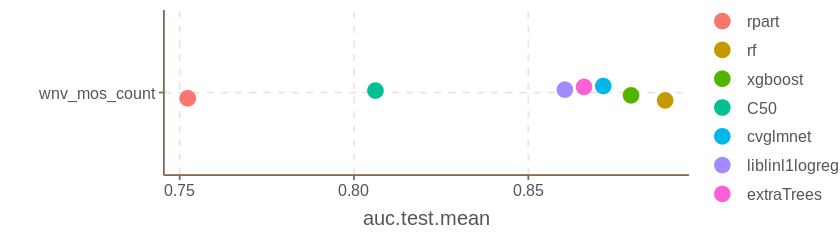

In [189]:
options(repr.plot.width=7, repr.plot.height=2)
plotBMRSummary(bmr)

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”

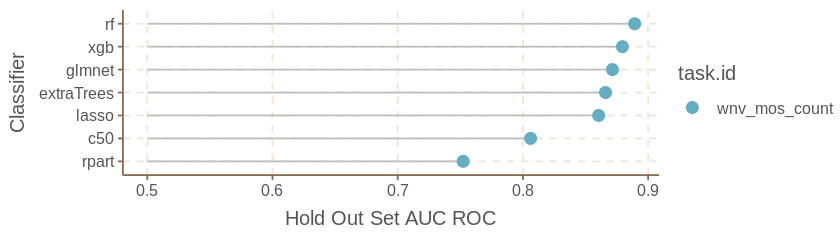

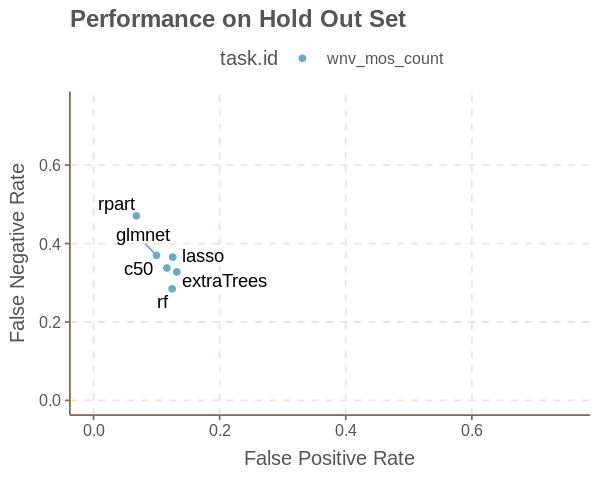

In [190]:
options(repr.plot.width=7, repr.plot.height=2)
getBMRAggrPerformances(bmr,as.df = T) %>%
    select(task.id, learner.id, auc.test.mean) %>%
    mutate(learner.id = forcats::fct_reorder(learner.id,auc.test.mean,.desc = F)) %>%
    ggplot(aes(learner.id, auc.test.mean))+
    geom_segment(aes(xend=learner.id,yend=0.5),color="gray")+
    geom_point(aes(color=task.id),size=3)+
    coord_flip()+
    labs(y="Hold Out Set AUC ROC",x="Classifier")

library("ggrepel")
ggthemr("fresh")
options(repr.plot.width=5, repr.plot.height=4)
getBMRAggrPerformances(bmr, as.df = T) %>%
    select(task.id, learner.id,fpr.test.mean,fnr.test.mean) %>%
    #bind_rows(list(learner.id="logistic_reg",fpr.test.mean=.119,fnr.test.mean=.078),
    #         list(learner.id="lda",fpr.test.mean=0.168,fnr.test.mean=.008),
    #         list(learner.id="neg_binomial",fpr.test.mean=0.121,fnr.test.mean=.087))%>%
    ggplot(aes(x=fpr.test.mean, y=fnr.test.mean)) +
    geom_point(aes(color=task.id))+
    geom_text_repel(aes(label=learner.id),force = 6,segment.colour = "#65ADC2")+
    theme(legend.position = "top")+
    scale_y_continuous(limits = c(0,.75))+
    scale_x_continuous(limits = c(0,.75))+
    labs(x="False Positive Rate", y="False Negative Rate", title = "Performance on Hold Out Set")

In [191]:
df = generateThreshVsPerfData(bmr, measures = list(fpr, tpr, mmce),task.id = "wnv_mos_count")

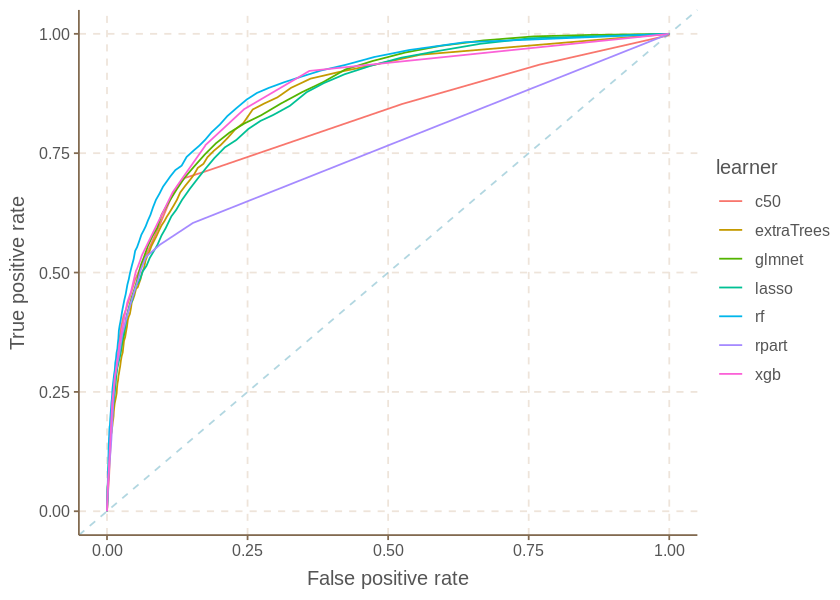

In [192]:
options(repr.plot.width=7, repr.plot.height=5)
plotROCCurves(df)

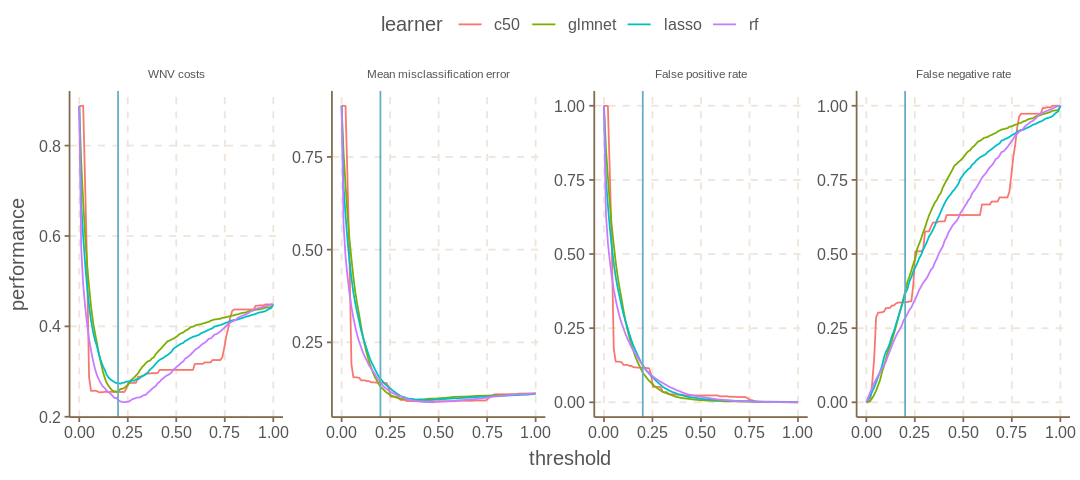

In [193]:
d = generateThreshVsPerfData(bmr$results$wnv_mos_count[c("rf","lasso","c50","glmnet")], 
                             measures = list(wnv.costs, mmce, fpr, fnr))
options(repr.plot.width=9, repr.plot.height=4)
plotThreshVsPerf(d, mark.th = th, facet.wrap.nrow = 1) +
    theme(strip.text.x = element_text(size = 7), legend.position = "top")

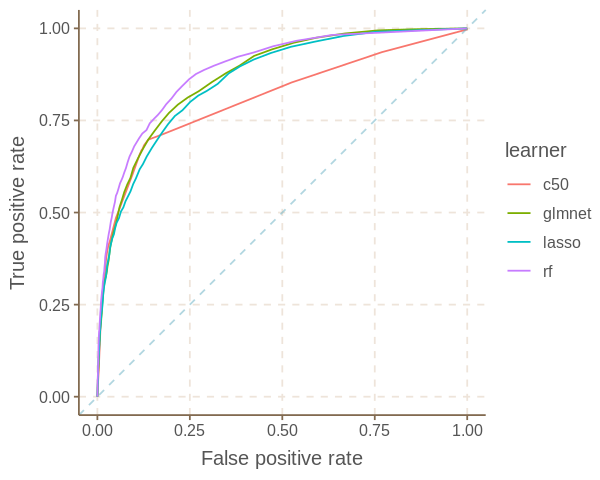

In [194]:
options(repr.plot.width=5, repr.plot.height=4)
generateThreshVsPerfData(bmr$results$wnv_mos_count[c("lasso","c50","glmnet","rf")], 
                         measures = list(fpr, tpr, mmce),task.id = "wnv_mos_count") %>%
    plotROCCurves()

saveRDS(object = bmr, file = "bmr_001.RData")

# Tuning

## Tune Random Forest

Without tuning, the baseline result...

In [195]:
preds = getBMRPredictions(bmr,task.ids = "wnv_mos_count", learner.ids = "rf",drop = T)

In [196]:
calculateROCMeasures(preds)

          predicted
true       Clean     Infected                      
  Clean    9008      1283      tpr: 0.72 fnr: 0.28 
  Infected 370       930       fpr: 0.12 tnr: 0.88 
           ppv: 0.42 for: 0.04 lrp: 5.74 acc: 0.86 
           fdr: 0.58 npv: 0.96 lrm: 0.33 dor: 17.65


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [197]:
ctrl = makeTuneControlGrid(tune.threshold = FALSE)
ctrl

Tune control: TuneControlGrid
Same resampling instance: TRUE
Imputation value: <worst>
Start: <NULL>

Tune threshold: FALSE
Further arguments: resolution=10

In [198]:
getLearnerParamSet(lrn_list[[2]])

                     Type  len   Def   Constr Req Tunable Trafo
ntree             integer    -   500 1 to Inf   -    TRUE     -
mtry              integer    -     - 1 to Inf   -    TRUE     -
replace           logical    -  TRUE        -   -    TRUE     -
classwt     numericvector <NA>     - 0 to Inf   -    TRUE     -
cutoff      numericvector <NA>     -   0 to 1   -    TRUE     -
strata            untyped    -     -        -   -   FALSE     -
sampsize    integervector <NA>     - 1 to Inf   -    TRUE     -
nodesize          integer    -     1 1 to Inf   -    TRUE     -
maxnodes          integer    -     - 1 to Inf   -    TRUE     -
importance        logical    - FALSE        -   -    TRUE     -
localImp          logical    - FALSE        -   -    TRUE     -
proximity         logical    - FALSE        -   -   FALSE     -
oob.prox          logical    -     -        -   Y   FALSE     -
norm.votes        logical    -  TRUE        -   -   FALSE     -
do.trace          logical    - FALSE    

In [199]:
ps = makeParamSet(
    makeDiscreteParam("ntree", values = c(150,300)),
    makeDiscreteParam("mtry", values = c(20,50,70,100)),
    makeLogicalParam("replace",tunable = T))
ps

            Type len Def       Constr Req Tunable Trafo
ntree   discrete   -   -      150,300   -    TRUE     -
mtry    discrete   -   - 20,50,70,100   -    TRUE     -
replace  logical   -   -            -   -    TRUE     -

In [200]:
(lrn_rf = makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob", predict.threshold = th))

Learner rf from package randomForest
Type: classif
Name: Random Forest; Short name: rf
Class: classif.randomForest
Properties: twoclass,multiclass,numerics,factors,ordered,prob,class.weights,oobpreds,featimp
Predict-Type: prob
Hyperparameters: 


In [201]:
parallelStartSocket(cpus = 39)
res_rf = tuneParams(learner = lrn_rf, measures = meas, 
                 task = tsk_mos_count, 
                 resampling = rdesc,  
                 par.set = ps, 
                 control = ctrl)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
[Tune] Started tuning learner rf for parameter set:
            Type len Def       Constr Req Tunable Trafo
ntree   discrete   -   -      150,300   -    TRUE     -
mtry    discrete   -   - 20,50,70,100   -    TRUE     -
replace  logical   -   -            -   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0Imputation value: 1Imputation value: -0Imputation value: -0Imputation value: 1Imputation value: 1Imputation value: -0Imputation value: 5
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 16.
[Tune] Result: ntree=300; mtry=50; replace=TRUE : auc.test.mean=0.8934515,mmce.test.mean=0.1369165,f1.test.mean=0.5446614,tpr.test.mean=0.7299997,fpr.test.mean=0.1201049,fnr.test.mean=0.2700003,ppv.test.mean=0.4344523,wnv.costs.test.mean=0.2277628
Stopped parallelization. All cleaned up.


parallelStartSocket(cpus = 39)

rdesc_cv = makeResampleDesc("CV", iters = 3, stratify = TRUE)

meas = list(auc, mmce, f1, tpr, fpr, fnr, kappa, ppv)

lrn_rf = makeLearner(cl = "classif.randomForest", predict.type = "prob")
#res = tuneParams(learner = lrn_rf, task = tsk_mos_count, resampling = rdesc_cv, par.set = ps, control = ctrl, measures = meas,show.info = TRUE)

lrn_wrap = makeTuneWrapper(learner = lrn_rf, par.set = ps, control = ctrl, resampling = rdesc_cv)

res = resample(learner = lrn_wrap, task = tsk_mos_count, resampling = rdesc_cv, measures = meas, extract = getTuneResult, show.info = TRUE)

#r = resample(lrn_wrap, tsk_mos_count, rdesc_cv, extract = getTuneResult)
parallelStop()

In [216]:
res_df = generateHyperParsEffectData(res_rf,partial.dep = T)[[1]]
res_df$ntree = as.factor(res_df$ntree)
res_df

ntree,mtry,replace,auc.test.mean,mmce.test.mean,f1.test.mean,tpr.test.mean,fpr.test.mean,fnr.test.mean,ppv.test.mean,wnv.costs.test.mean,iteration,exec.time
150,20,TRUE,0.8920468,0.1354494,0.5451308,0.7238251,0.1176750,0.2761749,0.4374143,0.2283678,1,66.138
300,20,TRUE,0.8921639,0.1375199,0.5421921,0.7261417,0.1202987,0.2738583,0.4327081,0.2296613,2,106.379
150,50,TRUE,0.8932535,0.1363122,0.5462667,0.7315358,0.1196187,0.2684642,0.4359215,0.2266410,3,77.714
300,50,TRUE,0.8934515,0.1369165,0.5446614,0.7299997,0.1201049,0.2700003,0.4344523,0.2277628,4,121.389
150,70,TRUE,0.8899796,0.1420922,0.5370405,0.7346168,0.1265178,0.2653832,0.4232563,0.2313855,5,85.141
300,70,TRUE,0.8914012,0.1389863,0.5412008,0.7307695,0.1225337,0.2692305,0.4298412,0.2295738,6,128.673
150,100,TRUE,0.8875969,0.1426963,0.5346478,0.7307731,0.1267123,0.2692269,0.4215433,0.2332835,7,89.584
300,100,TRUE,0.8892454,0.1428689,0.5327864,0.7261541,0.1263236,0.2738459,0.4207788,0.2350093,8,140.874
150,20,FALSE,0.8902910,0.1351906,0.5435076,0.7176807,0.1166062,0.2823193,0.4374975,0.2301789,9,64.453
300,20,FALSE,0.8934466,0.1350178,0.5462614,0.7246021,0.1172863,0.2753979,0.4385533,0.2276769,10,105.555


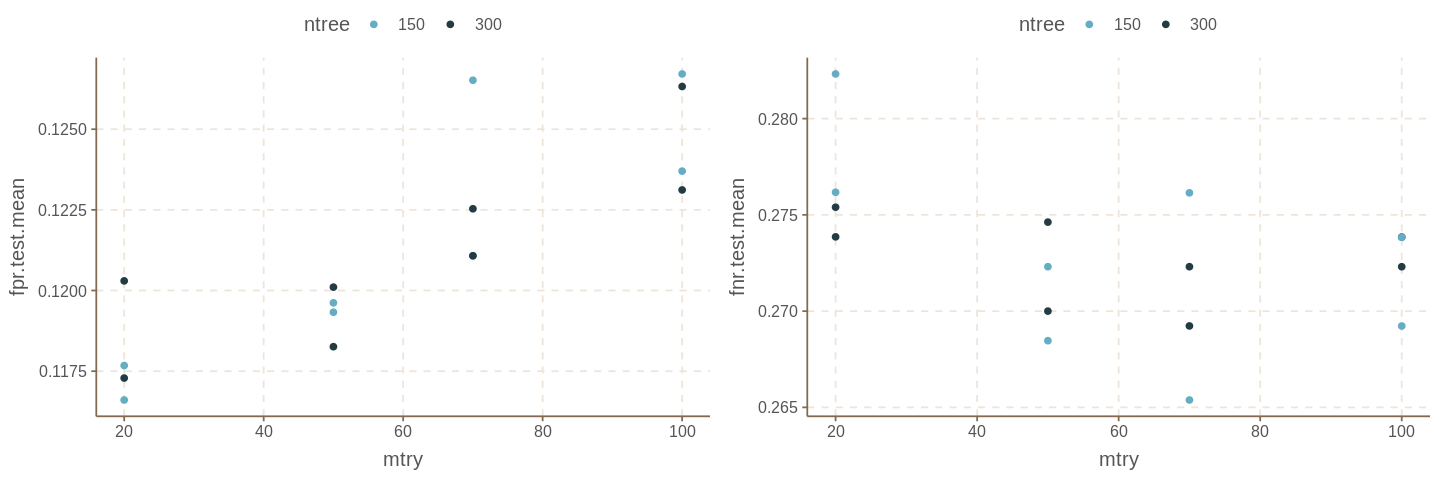

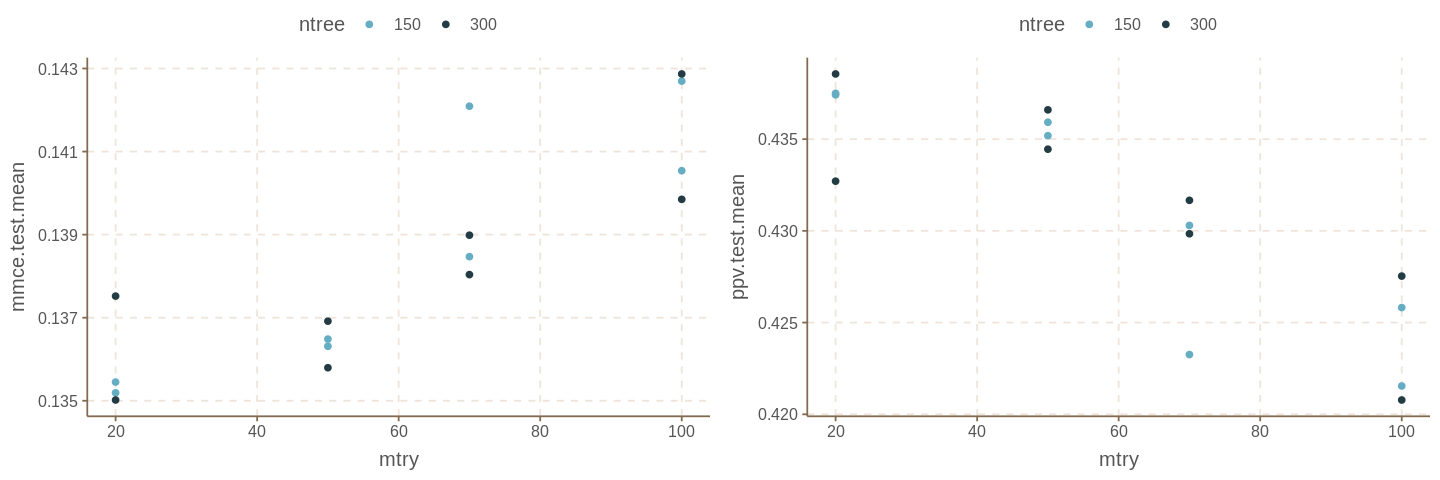

In [218]:
options(repr.plot.width=12, repr.plot.height=4)
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = fpr.test.mean, color = ntree)) +
    theme(legend.position = "top")-> p1
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = fnr.test.mean, color = ntree)) +
    theme(legend.position = "top") -> p2
cowplot::plot_grid(p1,p2)
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = mmce.test.mean, color = ntree)) +
    theme(legend.position = "top")-> p1
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = ppv.test.mean, color = ntree)) +
    theme(legend.position = "top") -> p2
cowplot::plot_grid(p1,p2)

In [204]:
parallelStartSocket(cpus = 39)
lrn_rf = setHyperPars(makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob", predict.threshold = th), 
                      par.vals = res_rf$x)
r = resample(learner = lrn_rf, task = tsk_mos_count, resampling = rdesc, measures = meas)
pred = getRRPredictions(r)
calculateROCMeasures(pred)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Resampling: cross-validation
Measures:             auc         mmce        f1          tpr         fpr         fnr         ppv         wnv.costs   
Mapping in parallel: mode = socket; cpus = 39; elements = 3.


Aggregated Result: auc.test.mean=0.8943843,mmce.test.mean=0.1332064,f1.test.mean=0.5568567,tpr.test.mean=0.7461411,fpr.test.mean=0.1179670,fnr.test.mean=0.2538589,ppv.test.mean=0.4442501,wnv.costs.test.mean=0.2186176




          predicted
true       Clean     Infected                      
  Clean    9077      1214      tpr: 0.75 fnr: 0.25 
  Infected 330       970       fpr: 0.12 tnr: 0.88 
           ppv: 0.44 for: 0.04 lrp: 6.33 acc: 0.87 
           fdr: 0.56 npv: 0.96 lrm: 0.29 dor: 21.98


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

Stopped parallelization. All cleaned up.


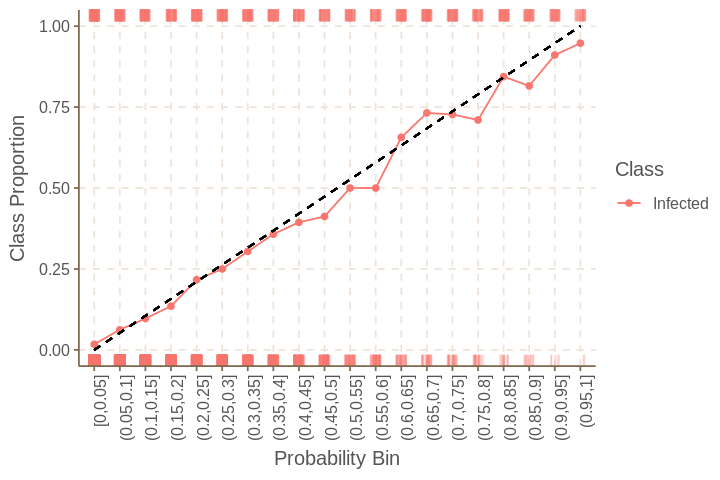

In [205]:
options(repr.plot.width=6, repr.plot.height=4)
cal = generateCalibrationData(pred)
plotCalibration(cal, smooth = F)

In [206]:
setThreshold(pred, threshold = .5) %>% calculateROCMeasures

          predicted
true       Clean    Infected                      
  Clean    10054    237       tpr: 0.43  fnr: 0.57
  Infected 745      555       fpr: 0.02  tnr: 0.98
           ppv: 0.7 for: 0.07 lrp: 18.54 acc: 0.92
           fdr: 0.3 npv: 0.93 lrm: 0.59  dor: 31.6


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [207]:
setThreshold(pred, threshold = th) %>% calculateROCMeasures

          predicted
true       Clean     Infected                      
  Clean    9074      1217      tpr: 0.74 fnr: 0.26 
  Infected 332       968       fpr: 0.12 tnr: 0.88 
           ppv: 0.44 for: 0.04 lrp: 6.3  acc: 0.87 
           fdr: 0.56 npv: 0.96 lrm: 0.29 dor: 21.74


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

## Tune GLMNet

What parameters can be tuned for a glmnet model?

In [208]:
glmnet_ps = makeParamSet(
      makeNumericParam("alpha", lower = 0, upper = 1)
)

In [209]:
ctrl = makeTuneControlRandom(maxit = 20L)

In [210]:
lrn_glmnet = makeLearner(id = "glmnet", cl = "classif.cvglmnet", predict.type = "prob", predict.threshold = th)

In [211]:
parallelStartSocket(cpus = 39)
res = tuneParams(learner = lrn_glmnet, measures = meas, 
                 task = tsk_mos_count, 
                 resampling = rdesc,  
                 par.set = glmnet_ps, 
                 control = ctrl)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
[Tune] Started tuning learner glmnet for parameter set:
         Type len Def Constr Req Tunable Trafo
alpha numeric   -   - 0 to 1   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0Imputation value: 1Imputation value: -0Imputation value: -0Imputation value: 1Imputation value: 1Imputation value: -0Imputation value: 5
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 20.
[Tune] Result: alpha=0.909 : auc.test.mean=0.8718705,mmce.test.mean=0.1307043,f1.test.mean=0.5183732,tpr.test.mean=0.6269108,fpr.test.mean=0.1000876,fnr.test.mean=0.3730892,ppv.test.mean=0.4421512,wnv.costs.test.mean=0.2562327
Stopped parallelization. All cleaned up.


In [212]:
res

Tune result:
Op. pars: alpha=0.909
auc.test.mean=0.8718705,mmce.test.mean=0.1307043,f1.test.mean=0.5183732,tpr.test.mean=0.6269108,fpr.test.mean=0.1000876,fnr.test.mean=0.3730892,ppv.test.mean=0.4421512,wnv.costs.test.mean=0.2562327

In [213]:
res_df = generateHyperParsEffectData(res,partial.dep = T)[[1]]
res_df

alpha,auc.test.mean,mmce.test.mean,f1.test.mean,tpr.test.mean,fpr.test.mean,fnr.test.mean,ppv.test.mean,wnv.costs.test.mean,iteration,exec.time
0.3112194,0.8696969,0.1344140,0.5144303,0.6346215,0.10523733,0.3653785,0.4325323,0.2573536,1,373.214
0.7545431,0.8717045,0.1313946,0.5172847,0.6276806,0.10096224,0.3723194,0.4401342,0.2566639,2,428.714
0.6593144,0.8713202,0.1316534,0.5176900,0.6299901,0.10154502,0.3700099,0.4394588,0.2561462,3,422.541
0.6578547,0.8710163,0.1295830,0.5202367,0.6269250,0.09882456,0.3730750,0.4447475,0.2551105,4,422.677
0.5003097,0.8709422,0.1324298,0.5202444,0.6400067,0.10368240,0.3599933,0.4382581,0.2535576,5,410.788
0.3028913,0.8696332,0.1338963,0.5151822,0.6338499,0.10455712,0.3661501,0.4340106,0.2570948,6,375.307
0.9431344,0.8714174,0.1304456,0.5160097,0.6200108,0.09892140,0.3799892,0.4418925,0.2583027,7,435.950
0.9092879,0.8718705,0.1307043,0.5183732,0.6269108,0.10008761,0.3730892,0.4421512,0.2562327,8,436.726
0.7926640,0.8712303,0.1301867,0.5180453,0.6238564,0.09911548,0.3761436,0.4429269,0.2567496,9,426.520
0.5621474,0.8708824,0.1311357,0.5178071,0.6276860,0.10067044,0.3723140,0.4407581,0.2564048,10,414.117
